In [1]:
import os
import glob
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata, ttest_rel, ttest_1samp
from scipy.stats import pearsonr,spearmanr

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns


import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE


from nilearn.image import new_img_like

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np

def regress_out(vec, control_matrices, upper_triangle_indices, standardize):
    """
    对给定的向量进行回归，剥离控制变量的影响，先标准化再回归（可选）。
    
    参数:
    - vec: np.array, 待剥离影响的向量
    - control_matrices: list of np.array, 控制变量的矩阵列表
    - upper_triangle_indices: tuple, 矩阵上三角的索引
    - standardize: bool, 是否先标准化数据，默认值为 True
    
    返回:
    - residuals: np.array, 回归后的残差
    """
    if control_matrices is None or len(control_matrices) == 0:
        return vec  # 如果没有控制变量，直接返回原始向量
    
    # 如果需要标准化，先标准化 vec
    if standardize:
        scaler = StandardScaler()
        vec_scaled = scaler.fit_transform(vec.reshape(-1, 1)).flatten()
    else:
        vec_scaled = vec
    
    # 收集控制变量的标准化版本（如果需要）
    control_vectors = []
    for control_matrix in control_matrices:
        control_vec = control_matrix[upper_triangle_indices]
        if standardize:
            control_vec_scaled = scaler.fit_transform(control_vec.reshape(-1, 1)).flatten()
        else:
            control_vec_scaled = control_vec
        control_vectors.append(control_vec_scaled)
    
    # 拼接控制变量矩阵
    control_matrix = np.column_stack(control_vectors)

    # 执行回归
    model = LinearRegression().fit(control_matrix, vec_scaled)
    
    # 计算残差
    residuals = vec_scaled - model.predict(control_matrix)
    
    return residuals

def mantel_with_multiple_controls(matrix1, matrix2, control_matrices=None, corr_type='spearman', permutations=1000, tail=2, standardize=True):
    """
    执行带有多个控制变量的 Mantel Test，包含置换检验。
    
    参数:
    - matrix1: np.array, 第一个距离矩阵 (NxN)
    - matrix2: np.array, 第二个距离矩阵 (NxN)
    - control_matrices: list of np.array, 控制变量的矩阵列表（默认为 None）
    - permutations: int, 置换次数
    - tail: int, p值的类型，1 表示单尾，2 表示双尾
    
    返回:
    - r_obs: 观察到的 Pearson 或 Spearman 相关系数
    - p_value: 置换检验的 p 值
    """
    # 确保输入矩阵是方阵
    assert matrix1.shape == matrix2.shape, "两个矩阵的形状必须相同"
    assert matrix1.shape[0] == matrix1.shape[1], "输入必须是方阵"
    
    # 提取上三角部分（不包括对角线）
    upper_triangle_indices = np.triu_indices_from(matrix1, k=1)
    vec1 = matrix1[upper_triangle_indices]
    vec2 = matrix2[upper_triangle_indices]
    
    # 对每个控制矩阵进行回归，剥离控制变量的影响
    residuals1 = regress_out(vec1, control_matrices, upper_triangle_indices,standardize=standardize)
    residuals2 = regress_out(vec2, control_matrices, upper_triangle_indices,standardize=standardize)
    
    # 计算观察到的相关系数
    if corr_type == 'pearson':
        r_obs, _ = pearsonr(residuals1, residuals2)
    elif corr_type == 'spearman':
        r_obs, _ = spearmanr(residuals1, residuals2)
    
    # 进行置换检验
    permuted_r = []
    n = matrix1.shape[0]
    
    for _ in range(permutations):
        # 随机打乱行列索引
        perm_indices = np.random.permutation(n)
        
        # 重新排列矩阵
        perm_matrix2 = matrix2[np.ix_(perm_indices, perm_indices)]
        
        # 对每个控制变量矩阵也进行相同的置换（如果存在控制变量）
        perm_control_matrices = []
        if control_matrices is not None:
            for control_matrix in control_matrices:
                perm_control_matrix = control_matrix[np.ix_(perm_indices, perm_indices)]
                perm_control_matrices.append(perm_control_matrix)
        
        # 提取置换后的上三角部分
        perm_vec2 = perm_matrix2[upper_triangle_indices]
        
        # 对置换后的矩阵进行回归，剥离控制变量的影响
        perm_residuals2 = regress_out(perm_vec2, perm_control_matrices, upper_triangle_indices, standardize=standardize)
        
        # 计算置换后的相关系数
        if corr_type == 'pearson':
            r_perm, _ = pearsonr(residuals1, perm_residuals2)
        elif corr_type == 'spearman':
            r_perm, _ = spearmanr(residuals1, perm_residuals2)
        
        permuted_r.append(r_perm)
    
    # 计算双尾或单尾 p 值
    p_value = _calc_pvalue(np.array(permuted_r), r_obs, tail)
    
    return r_obs, p_value

def _calc_pvalue(all_p, stat, tail):
    """计算基于置换分布的 p 值
    
    参数：
    - all_p: 置换分布的相关系数列表
    - stat: 观察到的统计量（如统计结果中的相关系数）
    - tail: (int) 1 或 2，表示单尾或双尾 p 值
    
    返回：
    - p_value: 计算得到的 p 值
    """
    denom = float(len(all_p)) + 1
    if tail == 1:
        numer = np.sum(all_p >= stat) + 1 if stat >= 0 else np.sum(all_p <= stat) + 1
    elif tail == 2:
        numer = np.sum(np.abs(all_p) >= np.abs(stat)) + 1
    else:
        raise ValueError("tail 必须是 1 或 2")
    return numer / denom


In [3]:
cor_brain_data = np.load('/Volumes/Li/task-persuade/braindata/denoised 5/parcel data/Schaefer align 5 runs/subs_data.npy')

# sub_brain_data = np.load('/Users/li/Desktop/task-persuade/braindata/parcel data/Harvard Oxford stack 5 runs/subs_data.npy')
# use_sub = [4, 5, 6, 7, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21]
# indices = [i - 1 for i in use_sub]
# sub_brain_data = sub_brain_data[:, :, indices] 
# all_brain_data = all_brain_data = np.concatenate((cor_brain_data, sub_brain_data), axis=2)

all_brain_data = cor_brain_data
print('all_brain_data.shape:', all_brain_data.shape)
brain_correlation_matrices = []

for pacel in range(all_brain_data.shape[2]):
    brain_correlation_matrices.append(Adjacency(1 - pairwise_distances(all_brain_data[:, :, pacel], metric='correlation'), matrix_type='similarity'))
brain_ISC = Adjacency(brain_correlation_matrices)
brain_ISC_np = np.array(brain_ISC.squareform())
print('brain_ISC_np.shape:',brain_ISC_np.shape)
brain_ISC_Z_np = np.arctanh(brain_ISC_np)

mask_file = '/Users/li/Desktop/template/Schaefer/tpl-MNI152NLin2009cAsym_res-02_atlas-Schaefer2018_desc-200Parcels7Networks_dseg.nii.gz'
mask_img = nib.load(mask_file)
mask_data = mask_img.get_fdata()
nw_labels = pd.read_csv('/Users/li/Desktop/template/Schaefer/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
roi_name = list(nw_labels['ROI Name'])
# + ['Left Thalamus','Left Caudate','Left Putamen','Left Pallidum','Left Hippocampus','Left Amygdala','Left Accumbens',
#                                           'Right Thalamus','Right Caudate','Right Putamen','Right Pallidum','Right Hippocampus','Right Amygdala','Right Accumbens']


sns.heatmap(brain_ISC_np.mean(axis=0))

all_brain_data.shape: (35, 1165, 200)
brain_ISC_np.shape: (200, 35, 35)


<Axes: >

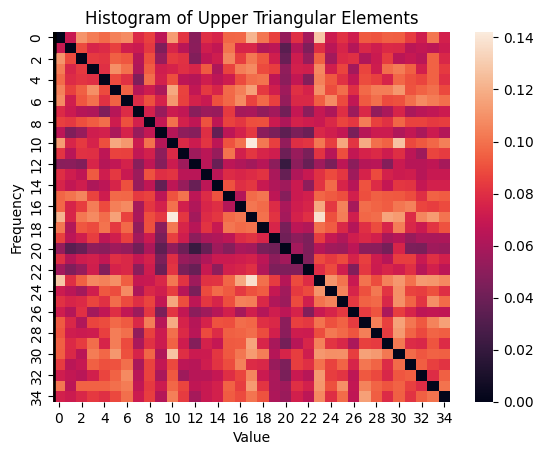

In [4]:

array = brain_ISC_np.mean(axis=0)
upper_triangle_elements = array[np.triu_indices(array.shape[0], k=1)]
min_val = int(np.floor(upper_triangle_elements.min()))
max_val = int(np.ceil(upper_triangle_elements.max()))

# 设置 bins 为范围内的所有整数
bins = np.arange(min_val, max_val+1)
# 绘制上三角元素的直方图
plt.hist(upper_triangle_elements, bins=20, edgecolor='black')
plt.title('Histogram of Upper Triangular Elements')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [5]:

subs_change = pd.read_csv('/Users/li/Desktop/task-persuade/behavdata/subs_attitude_change.csv')
subs_change = np.array(subs_change.iloc[:])[:,1:]

print('subs_change.shape:',subs_change.shape)

distances = -pdist(subs_change, metric='euclidean')
dist_matrix = squareform(distances)


change_SM = squareform(distances)

sns.heatmap(change_SM, cmap='viridis', annot=False, square=True)


subs_change.shape: (35, 15)


<Axes: >

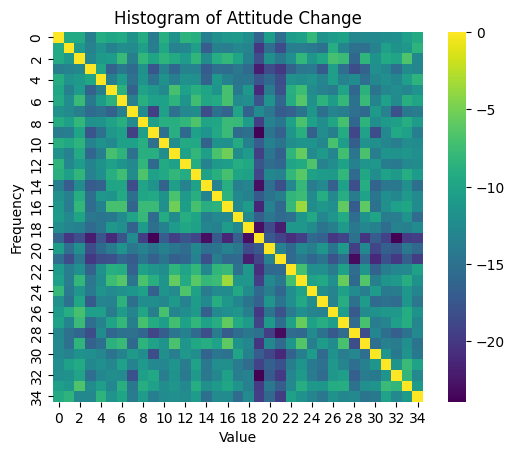

In [6]:
array = squareform(distances)
upper_triangle_elements = array[np.triu_indices(array.shape[0], k=1)]
min_val = int(np.floor(upper_triangle_elements.min()))
max_val = int(np.ceil(upper_triangle_elements.max()))

# 设置 bins 为范围内的所有整数
bins = np.arange(min_val, max_val+1)
# 绘制上三角元素的直方图
plt.hist(upper_triangle_elements, bins=20, edgecolor='black')
plt.title('Histogram of Attitude Change')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [7]:

subs_pre = pd.read_csv('/Users/li/Desktop/task-persuade/behavdata/subs_pre_attitude.csv')
subs_pre = np.array(subs_pre.iloc[:])[:,1:]
print('subs_pre.shape:',subs_pre.shape)
distances = -pdist(subs_pre, metric='euclidean')
pre_SM = squareform(distances)

subs_post = pd.read_csv('/Users/li/Desktop/task-persuade/behavdata/subs_post_attitude.csv')
subs_post = np.array(subs_post.iloc[:])[:,1:]
print('subs_post.shape:',subs_post.shape)
distances = -pdist(subs_post, metric='euclidean')
post_SM = squareform(distances)




subs_pre.shape: (35, 15)
subs_post.shape: (35, 15)


In [8]:
# 人格相似性

csv_file = '/Users/li/Desktop/task-persuade/behavdata/questionnaire.csv'
data = pd.read_csv(csv_file)

big5_list = [f'e{x}' for x in range(1,61)]
big5_items = data[big5_list]
personality_SM = squareform(-pdist(big5_items, metric='euclidean'))
# sns.heatmap(personality_SM)


selected_data = pd.read_csv('/Users/li/Desktop/task-persuade/behavdata/personality.csv')
ages = selected_data['age'].values
age_diff_matrix = np.abs(ages[:, np.newaxis] - ages)

sex = selected_data['sex'].values
sex_diff_matrix = np.abs(sex[:, np.newaxis] - sex)

IUS = selected_data['IUS'].values
joint_IUS = (IUS[:, np.newaxis] + IUS)/2


In [9]:
mantel_with_multiple_controls(change_SM, brain_ISC_Z_np[83],
                                        standardize=True, corr_type='pearson',
                                        # control_matrices = [pre_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=100000,tail=2)

(0.14457145589257933, 0.0960290397096029)

In [10]:
mantel_with_multiple_controls(change_SM, brain_ISC_Z_np[83],
                                        standardize=True, corr_type='pearson',
                                        control_matrices = [pre_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=100000,tail=2)

(0.15135201469443607, 0.07171928280717192)

In [9]:

rlist1, plist1 = [],[]
for roi in range(200):

    r, p = mantel_with_multiple_controls(change_SM, brain_ISC_Z_np[roi],
                                        standardize=True, corr_type='pearson',
                                        control_matrices = [pre_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=10000,tail=2)
    if p <0.05:
        print(f'{roi},{r:.3f},{p}')

    rlist1.append(r)
    plist1.append(p)



8,0.210,0.029197080291970802
23,0.157,0.007499250074992501
25,0.119,0.019998000199980003
33,0.150,0.019998000199980003
44,0.179,0.004999500049995001
45,0.133,0.04609539046095391
52,0.147,0.037396260373962605
53,0.160,0.0435956404359564
66,0.166,0.026697330266973303
77,0.238,0.045795420457954206
89,0.157,0.035896410358964105
91,0.161,0.03189681031896811
103,0.233,0.0201979802019798
110,0.219,0.042195780421957804
123,0.116,0.044795520447955206
127,0.123,0.0410958904109589
128,0.134,0.026697330266973303
135,0.282,0.006199380061993801
136,0.171,0.010498950104989501
137,0.315,0.0034996500349965005
153,0.194,0.0093990600939906
164,0.220,0.017198280171982803
165,0.213,0.0408959104089591
168,0.152,0.030296970302969704
180,0.168,0.0352964703529647
187,0.205,0.0324967503249675
194,0.146,0.025197480251974803
195,0.154,0.0461953804619538


In [10]:
rlist2, plist2 = [],[]
for roi in range(200):
    r, p = mantel_with_multiple_controls(change_SM, brain_ISC_Z_np[roi],
                                        standardize=True, corr_type='pearson',
                                        # control_matrices = [pre_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=10000,tail=2)
    if p <0.05:
        print(f'{roi},{r:.3f},{p}')

    rlist2.append(r)
    plist2.append(p)

8,0.214,0.0334966503349665
23,0.164,0.006099390060993901
25,0.134,0.0096990300969903
33,0.154,0.024197580241975804
44,0.166,0.0122987701229877
52,0.146,0.044195580441955803
66,0.189,0.0202979702029797
82,0.143,0.047295270472952705
89,0.172,0.025597440255974404
102,0.253,0.047995200479952004
103,0.229,0.0292970702929707
105,0.244,0.04609539046095391
127,0.131,0.032596740325967405
128,0.158,0.010498950104989501
130,0.120,0.036396360363963605
135,0.256,0.0143985601439856
136,0.174,0.013798620137986202
137,0.326,0.0026997300269973002
153,0.201,0.013498650134986502
164,0.211,0.027597240275972403
165,0.214,0.0466953304669533
168,0.153,0.0341965803419658
180,0.158,0.04659534046595341
195,0.162,0.04989501049895011


In [11]:

rlist3, plist3 = [],[]
for roi in range(200):

    r, p = mantel_with_multiple_controls(change_SM, brain_ISC_Z_np[roi],
                                        standardize=True, corr_type='spearman',
                                        control_matrices = [pre_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=10000,tail=2)
    if p <0.05:
        print(f'{roi},{r:.3f},{p}')

    rlist3.append(r)
    plist3.append(p)



8,0.201,0.0292970702929707
23,0.165,0.0033996600339966003
25,0.121,0.0165983401659834
44,0.153,0.011398860113988602
45,0.131,0.0463953604639536
103,0.224,0.0206979302069793
110,0.223,0.0332966703329667
111,0.213,0.049095090490950906
127,0.117,0.04509549045095491
135,0.258,0.009299070092990702
136,0.146,0.025697430256974303
137,0.287,0.0036996300369963003
153,0.169,0.022397760223977603
154,0.129,0.0405959404059594
164,0.218,0.0122987701229877
165,0.205,0.04129587041295871
168,0.137,0.043195680431956804
180,0.163,0.0268973102689731
187,0.208,0.030996900309969003
194,0.141,0.0206979302069793
196,0.134,0.024897510248975102


In [12]:

rlist4, plist4 = [],[]
for roi in range(200):

    r, p = mantel_with_multiple_controls(change_SM, brain_ISC_Z_np[roi],
                                        standardize=True, corr_type='spearman',
                                        # control_matrices = [pre_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=10000,tail=2)
    if p <0.05:
        print(f'{roi},{r:.3f},{p}')

    rlist4.append(r)
    plist4.append(p)



8,0.206,0.031096890310968902
9,0.162,0.036396360363963605
23,0.170,0.0037996200379962005
25,0.132,0.0105989401059894
33,0.129,0.04559544045595441
44,0.139,0.027497250274972504
66,0.158,0.04129587041295871
71,0.182,0.04509549045095491
89,0.159,0.033596640335966405
103,0.214,0.0301969803019698
127,0.116,0.0471952804719528
128,0.139,0.0226977302269773
135,0.239,0.0201979802019798
136,0.151,0.024197580241975804
137,0.304,0.0035996400359964
153,0.184,0.0160983901609839
154,0.138,0.0282971702829717
164,0.211,0.0188981101889811
165,0.211,0.04129587041295871
168,0.137,0.04279572042795721
194,0.135,0.042195780421957804


In [13]:
result_data = {
    'pearson control': rlist1,
    'p1': plist1,
    'pearson no-control': rlist2,
    'p2': plist2,
    'spearman control': rlist3,
    'p3': plist3,
    'spearman no-control': rlist4,
    'p4': plist4
}

result_data_df = pd.DataFrame(result_data)

result_data_df.to_csv('/Users/li/Desktop/debate2025/results/ISC-ISRSA-Exp2.csv', index=False)

In [14]:
mantel_with_multiple_controls(change_SM, brain_ISC_Z_np[89],
                                        standardize=True, corr_type='spearman',
                                        control_matrices = [pre_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=100000,tail=2)

(0.13761881600989334, 0.06165938340616594)

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# 生成一个示例无向图（连接矩阵可以替换为实际数据）
# 假设有21个节点，分成7组，每组有3个节点
G = nx.Graph()

# 假设有一个简单的连接矩阵，连接权重从1到5之间随机
adj_matrix = np.random.randint(1, 6, size=(21, 21))
np.fill_diagonal(adj_matrix, 0)  # 保证对角线为0（无自环）

# 将连接矩阵应用于图（使用 from_numpy_array）
G = nx.from_numpy_array(adj_matrix)

# 定义7组节点（每组3个节点）
groups = {
    0: [0, 1, 2],
    1: [3, 4, 5],
    2: [6, 7, 8],
    3: [9, 10, 11],
    4: [12, 13, 14],
    5: [15, 16, 17],
    6: [18, 19, 20]
}

# 为每组节点指定不同的颜色
group_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'yellow']

# 创建一个节点颜色的映射
node_colors = []
for i in range(G.number_of_nodes()):
    for group_id, nodes in groups.items():
        if i in nodes:
            node_colors.append(group_colors[group_id])

# 获取边的权重，并用权重来设置边的粗细
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

# 创建圆形布局
pos = nx.circular_layout(G)

# 获取边的颜色，基于节点颜色进行渐变
edges_color = []
for u, v in G.edges():
    color = np.mean([node_colors[u], node_colors[v]], axis=0)
    edges_color.append(color)

# 绘制图形
plt.figure(figsize=(10, 10))

# 绘制边，边的颜色是基于节点颜色的渐变
edge_colors = []
for u, v in G.edges():
    # 计算边的颜色渐变（这里简单取两个节点颜色的均值）
    edge_colors.append(node_colors[u])  # 简单地用起始节点的颜色作为边的颜色

# 绘制边，线条的宽度由权重决定
nx.draw_networkx_edges(G, pos=pos, width=edge_widths, edge_color=edge_colors, alpha=0.7)

# 绘制节点，节点颜色由所属组决定
nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=500)

# 绘制标签
nx.draw_networkx_labels(G, pos=pos, font_size=10, font_weight='bold')

# 设置标题并显示图形
plt.title("Social Network Visualization with Circular Layout and Edge Color Gradient")
plt.axis('off')  # 关闭坐标轴
plt.show()


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> None